#Classification Problem: To find the survival status(survived less than 5 years or longer) of a patient.

In [85]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.width', 200)
pd.set_option('display.max_columns', 40)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from PIL import Image

In [86]:
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest



In [87]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.3, psize=10, zfunc=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if mesh:
        if zfunc:
            p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
            p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
            Z=zfunc(p0, p1)
        else:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light, alpha=alpha, axes=ax)
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=ytr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    yact=clf.predict(Xte)
    ax.scatter(Xte[:, 0], Xte[:, 1], c=yte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [88]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1, prob=True):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha) 
    if prob:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    else:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

##Setting up the data

Data set has been collected from the UCI machine learning website.
It has total 4 attributes age,year, axillary nodes and the status column with either 0 or 1 vaues.

In [89]:
dfhw=pd.read_csv("haberman.csv")
print dfhw.shape
dfhw.head()

(306, 4)


,Status,Age,Year,NPAN
0,0,30,64,1
1,0,30,62,3
2,0,30,65,0
3,0,31,59,2
4,0,31,65,4


We sample 250 points from 306, since we actually want to see trends clearly on the plots

In [90]:
df=dfhw.sample(250, replace=False)
np.sum(df.Status==0)

184

We split the data into training and test sets...

In [91]:
itrain, itest = train_test_split(xrange(df.shape[0]), train_size=0.6)
mask=np.ones(df.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)
mask[:10]


array([False, False,  True, False, False, False,  True,  True,  True, False], dtype=bool)

## Using Logistic regression for classification



C:\Users\Saurabh Singh\Anaconda2\lib\site-packages\ipykernel\__main__.py:17: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


using mask
BEST {'C': 10} 0.726666666667 [mean: 0.70000, std: 0.02575, params: {'C': 0.001}, mean: 0.68667, std: 0.04494, params: {'C': 0.01}, mean: 0.69333, std: 0.03842, params: {'C': 0.1}, mean: 0.70667, std: 0.02715, params: {'C': 1}, mean: 0.72667, std: 0.03908, params: {'C': 10}, mean: 0.72667, std: 0.03908, params: {'C': 100}, mean: 0.72667, std: 0.03908, params: {'C': 1000}, mean: 0.72667, std: 0.03908, params: {'C': 10000}]
############# based on standard predict ################
Accuracy on training data: 0.72
Accuracy on test data:     0.79
[[ 4 16]
 [ 5 75]]
########################################################


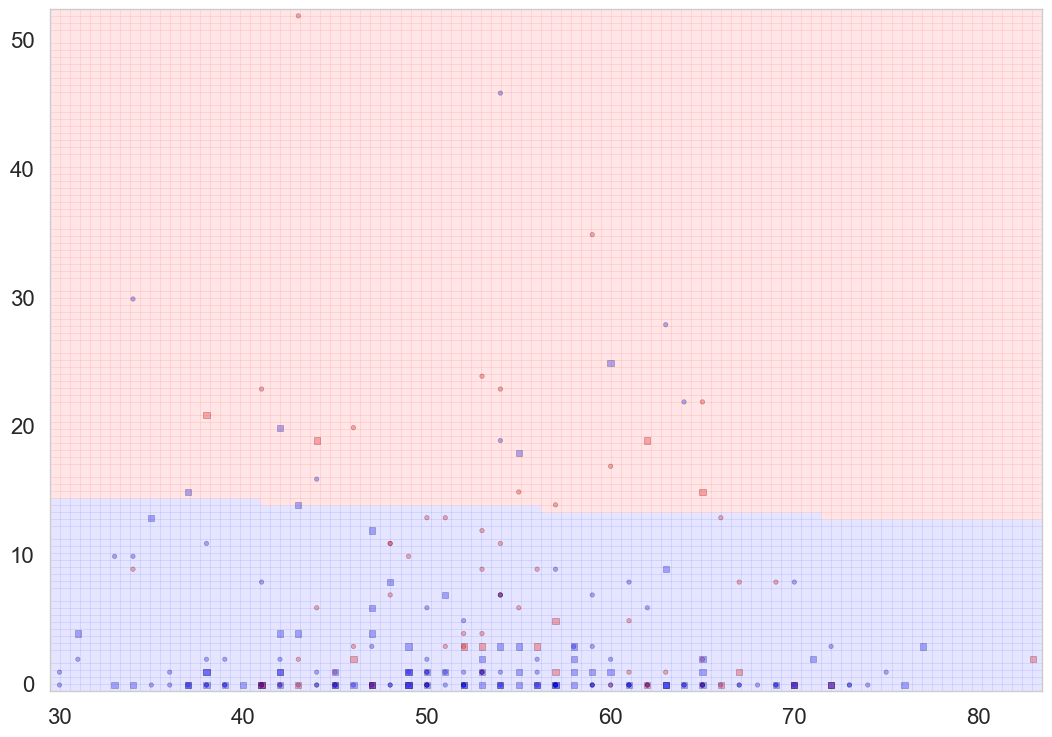

In [92]:
from sklearn.linear_model import LogisticRegression
clflog = LogisticRegression()
parameters = {"C": [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]}
clflog, Xtrain, ytrain, Xtest, ytest=do_classify(clflog, parameters, df, ['Age','NPAN'],'Status', 0 , mask=mask)
Xtr=np.concatenate((Xtrain, Xtest))
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog);

In `sklearn`, `clf.predict(test_data)` makes predictions on the assumption that a 0.5 probability threshold is the appropriate thing to do.

In [93]:
clflog.predict(Xtest)

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1])

The probabilities output by the classifier can be accessed as below. The second column (`[:,1]` in numpy parlance, google numpy indexing to understand the syntax) gives the probability that the sample is a 1 (or +ive), here Male.

In [94]:
clflog.predict_proba(Xtest)

array([[ 0.26424301,  0.73575699],
       [ 0.2662284 ,  0.7337716 ],
       [ 0.23093659,  0.76906341],
       [ 0.22555325,  0.77444675],
       [ 0.20666192,  0.79333808],
       [ 0.20833717,  0.79166283],
       [ 0.20777764,  0.79222236],
       [ 0.20224336,  0.79775664],
       [ 0.60964238,  0.39035762],
       [ 0.21744051,  0.78255949],
       [ 0.2243691 ,  0.7756309 ],
       [ 0.66419569,  0.33580431],
       [ 0.24438047,  0.75561953],
       [ 0.22092747,  0.77907253],
       [ 0.20777764,  0.79222236],
       [ 0.2279348 ,  0.7720652 ],
       [ 0.20389201,  0.79610799],
       [ 0.20610572,  0.79389428],
       [ 0.26490375,  0.73509625],
       [ 0.21793545,  0.78206455],
       [ 0.31924812,  0.68075188],
       [ 0.20777764,  0.79222236],
       [ 0.47201581,  0.52798419],
       [ 0.27484322,  0.72515678],
       [ 0.20666192,  0.79333808],
       [ 0.22092747,  0.77907253],
       [ 0.20334135,  0.79665865],
       [ 0.34396896,  0.65603104],
       [ 0.215712  ,

In [95]:
clflog.predict_proba(Xtest)[:,1]

array([ 0.73575699,  0.7337716 ,  0.76906341,  0.77444675,  0.79333808,
        0.79166283,  0.79222236,  0.79775664,  0.39035762,  0.78255949,
        0.7756309 ,  0.33580431,  0.75561953,  0.77907253,  0.79222236,
        0.7720652 ,  0.79610799,  0.79389428,  0.73509625,  0.78206455,
        0.68075188,  0.79222236,  0.52798419,  0.72515678,  0.79333808,
        0.77907253,  0.79665865,  0.65603104,  0.784288  ,  0.72447946,
        0.73969918,  0.78023929,  0.77503938,  0.79333808,  0.784288  ,
        0.77086779,  0.73632164,  0.78828236,  0.80102401,  0.78486195,
        0.73773286,  0.77907253,  0.74415678,  0.78771507,  0.47733643,
        0.78828236,  0.72175987,  0.36179788,  0.69450382,  0.73707529,
        0.73253866,  0.79885019,  0.4536833 ,  0.37602738,  0.75998229,
        0.77974055,  0.78371294,  0.74801657,  0.73641667,  0.78884855,
        0.80048222,  0.35488331,  0.78997759,  0.78023929,  0.7756309 ,
        0.78313677,  0.79444938,  0.7972082 ,  0.77026743,  0.78

Lots of sure less than 5 years and sure more than 5 years when you plot the probability of being more than 5 years:

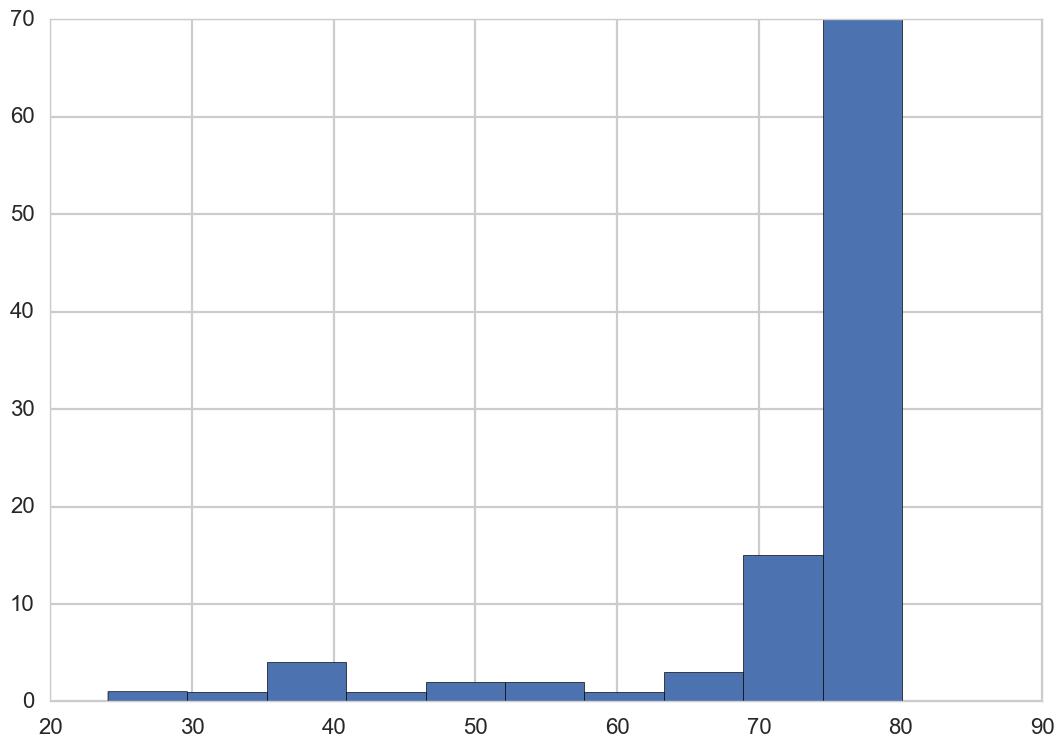

In [96]:
plt.hist(clflog.predict_proba(Xtest)[:,1]*100);

We can plot the probability contours: these are rather tight!

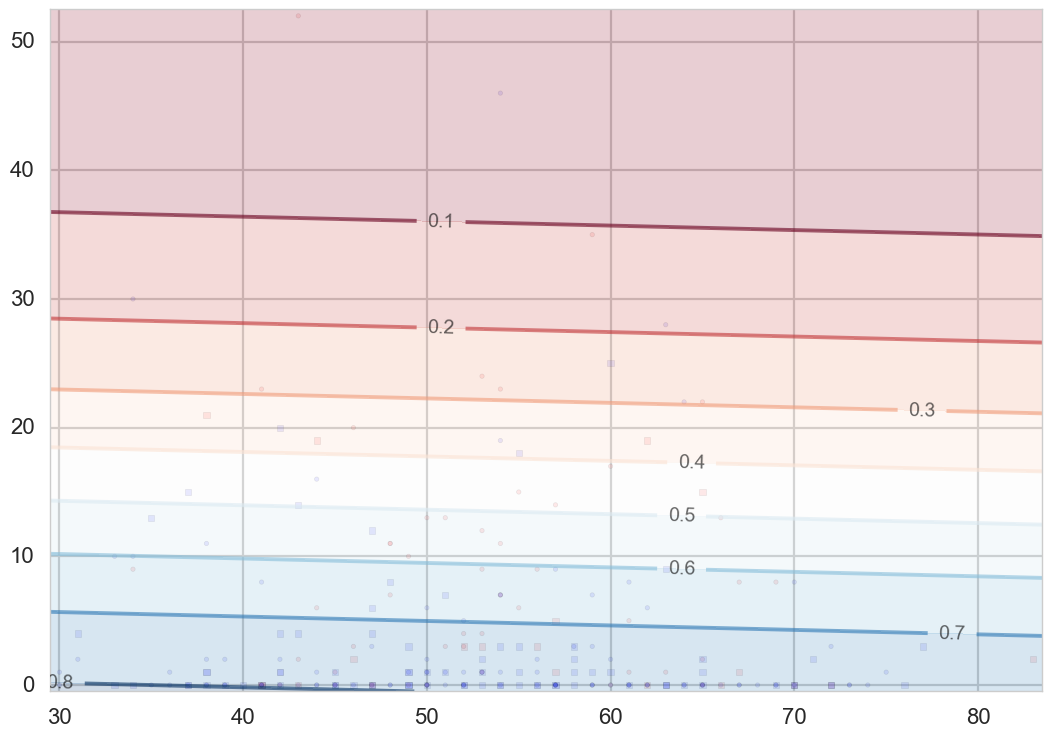

In [97]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, clflog, mesh=False, alpha=0.001);
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, clflog);

The score function of the estimator is used to evaluate a parameter setting. These are the sklearn.metrics.accuracy_score for classification and sklearn.metrics.r2_score for regression. For some applications, other scoring functions are better suited (for example in unbalanced classification, the accuracy score is often uninformative). We can pass other scorers to `GridSearchCV`.

In [105]:
clflog.score(Xtest, ytest)

0.79000000000000004

In [ ]:
The accuracy rate on test data set is 79%.
Other classification techniques such as SVM or Regression Trees could be used in future to classify this data sets and get better accuracy rate.